# Text Classification on a Subset of the Gutengerg Corpus
## Overview
* Import Data
* Characterizing the Corpus
* ...


In [1]:
# only for google colab
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/content/drive/My Drive/Colab Notebooks/ATiML-project-SS20')
#!cd "/content/drive/My Drive/Colab Notebooks/ATiML-project-SS20"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import spatial
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from ast import literal_eval
import re
from collections import defaultdict

In [3]:
from tqdm import tqdm
tqdm.pandas()

C:\Users\Rob\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Import Data

In [4]:
from corpus import load_corpus, save_corpus
corpus = load_corpus()
corpus = corpus.astype({
  'Book_Name': 'string',
  'guten_genre': 'category',
  'Author_Name': 'string',
  'content': 'string'
})
corpus.dropna(inplace=True)
corpus

Book_Name  \
book_id                                                                      
pg10067                  The Mystery of the Boule Cabinet: A Detective ...   
pg1032                                                           The Pupil   
pg10379                                                     At Love's Cost   
pg10473                                             The Heart of the Range   
pg10812                                        The Worshipper of the Image   
...                                                                    ...   
pg766DickensDavidCopfld                                  David Copperfield   
pg786DickensHardTimes                                           Hard Times   
pg834DoyleMemoirsSherlk                          Memoirs of Shelock Holmes   
pg863Agatha1                               The Mysterious Affair at Styles   
pg98DickensTaleCities                                 A Tale of Two Cities   

                                   guten_genre               Author_Name  \
book_id                                                                    
pg10067                  Detective and Mystery  Stevenson| Burton Egbert   
pg1032                                Literary              James| Henry   
pg10379                               Literary          Garvice| Charles   
pg10473                        Western Stories  White| William Patterson   
pg10812                               Literary     Gallienne| Richard Le   
...                                        ...                       ...   
pg766DickensDavidCopfld               Literary          Dickens| Charles   
pg786DickensHardTimes                 Literary          Dickens| Charles   
pg834DoyleMemoirsSherlk  Detective and Mystery             Connan| Doyle   
pg863Agatha1             Detective and Mystery          Christie| Agatha   
pg98DickensTaleCities                 Literary          Dickens| Charles   

                                                                   content  \
book_id                                                                      
pg10067                  A Detective Story
A.B.M. Fellow-Sherlockian
"H...   
pg1032                   This edition first published 1916
The text fol...   
pg10379                  "Until this moment I have never fully realised...   
pg10473                  "The Rider of Golden Bar," "Hidden Trails," "L...   
pg10812                  The Worshipper of the Image
Evening was in the...   
...                                                                    ...   
pg766DickensDavidCopfld  I do not find it easy to get sufficiently far ...   
pg786DickensHardTimes    The One Thing Needful
Murdering the Innocents
...   
pg834DoyleMemoirsSherlk  "I am afraid, Watson, that I shall have to go,...   
pg863Agatha1             The intense interest aroused in the public by ...   
pg98DickensTaleCities    !!!!  Book the First - Recalled to Life I.   T...   

                                                                    tokens  \
book_id                                                                      
pg10067                  ['A', 'Detective', 'Story', 'A.B.M', '.', 'Fel...   
pg1032                   ['This', 'edition', 'first', 'published', '191...   
pg10379                  ['``', 'Until', 'this', 'moment', 'I', 'have',...   
pg10473                  ['``', 'The', 'Rider', 'of', 'Golden', 'Bar', ...   
pg10812                  ['The', 'Worshipper', 'of', 'the', 'Image', 'E...   
...                                                                    ...   
pg766DickensDavidCopfld  ['I', 'do', 'not', 'find', 'it', 'easy', 'to',...   
pg786DickensHardTimes    ['The', 'One', 'Thing', 'Needful', 'Murdering'...   
pg834DoyleMemoirsSherlk  ['``', 'I', 'am', 'afraid', ',', 'Watson', ','...   
pg863Agatha1             ['The', 'intense', 'interest', 'aroused', 'in'...   
pg98DickensTaleCities    ['!', '!', '!', '!', 'Book', 'the', 'First', '...   

                               

In [5]:
for index, book in corpus.iterrows():
    rng = round(len(str(corpus.loc[index,"content"]).split())*(4/5))
    cli = round(len(str(corpus.loc[index,"content"]).split())*(1/10)) 
    a = corpus.loc[index,"content"].split()[rng:rng+cli]
    str1 = " "
    corpus.loc[index, "climax"] = str1.join(a)
    str1 = " "

In [6]:
save_corpus(corpus)

## Characterizing the Corpus

In [7]:
# ...

## Create Feature Collection

In [8]:
try:
  feature_collection = pd.read_csv('feature_collection.csv', index_col='book_id')
except:
  feature_collection = pd.DataFrame([], index=corpus.index)

In [9]:
# make sure all columns have a proper dtype before storing them
# and remove instances containing nan elements
feature_collection.to_csv('feature_collection.csv')

In [10]:
feature_collection


title_word_count  title_avg_word_length   ._count  \
book_id                                                                      
pg10067                                 9               4.777778  0.047124   
pg1032                                  2               4.000000  0.034161   
pg10379                                 3               4.000000  0.036540   
pg10473                                 5               3.600000  0.063323   
pg10812                                 5               4.600000  0.040540   
...                                   ...                    ...       ...   
pg766DickensDavidCopfld                 2               8.000000  0.034839   
pg786DickensHardTimes                   2               4.500000  0.038167   
pg834DoyleMemoirsSherlk                 4               5.500000  0.045144   
pg863Agatha1                            5               5.400000  0.056792   
pg98DickensTaleCities                   5               3.200000  0.035153   

                          !_count   ?_count   ,_count  ``_count  length  \
book_id                                                                   
pg10067                  0.003927  0.007425  0.065670  0.028751   86326   
pg1032                   0.003822  0.005542  0.045963  0.016149   20930   
pg10379                  0.006190  0.005673  0.064081  0.017677  183689   
pg10473                  0.003170  0.009745  0.050225  0.031861  115440   
pg10812                  0.005314  0.004233  0.067206  0.016131   21263   
...                           ...       ...       ...       ...     ...   
pg766DickensDavidCopfld  0.006531  0.004193  0.084033  0.000412  429805   
pg786DickensHardTimes    0.005037  0.004909  0.082862  0.000215  125474   
pg834DoyleMemoirsSherlk  0.002106  0.005615  0.058558  0.021029  104000   
pg863Agatha1             0.005689  0.011474  0.058872  0.030001   72598   
pg98DickensTaleCities    0.005978  0.005029  0.078704  0.013378   21079   

                         proper_names  pos_sentiment  neu_sentiment  \
book_id                                                               
pg10067                      0.002919          0.104          0.800   
pg1032                       0.004157          0.143          0.779   
pg10379                      0.002433          0.156          0.759   
pg10473                      0.003067          0.100          0.824   
pg10812                      0.003715          0.163          0.715   
...                               ...            ...            ...   
pg766DickensDavidCopfld      0.003455          0.138          0.779   
pg786DickensHardTimes        0.006607          0.122          0.794   
pg834DoyleMemoirsSherlk      0.005471          0.099          0.817   
pg863Agatha1                 0.003223          0.112          0.784   
pg98DickensTaleCities        0.008350          0.099          0.813   

                         neg_sentiment  point_of_view  
book_id                                                
pg10067                          0.096       0.644986  
pg1032                           0.078       0.272887  
pg10379                          0.085       0.456420  
pg10473                          0.076       0.575733  
pg10812                          0.122       0.318627  
...                                ...            ...  
pg766DickensDavidCopfld          0.083       0.708288  
pg786DickensHardTimes            0.083       0.522765  
pg834DoyleMemoirsSherlk          0.084       0.649575  
pg863Agatha1                     0.105       0.669434  
pg98DickensTaleCities            0.089       0.467312  

[996 rows x 13 columns]

## Extract Features from the Book Title
* word count
* average word length

In [11]:
feature = 'title_word_count'
feature_collection[feature] = None
for index, book in corpus.iterrows():
    try:
        feature_collection.loc[index, feature] = len(book['Book_Name'].split(' '))
    except ZeroDivisionError:
        print('book tile length 0 for {}'.format(index))
        feature_collection.loc[index, feature] = None

In [12]:
feature = 'title_avg_word_length'
feature_collection[feature] = None
for index, book in corpus.iterrows():
    try:
        words = book['Book_Name'].split(' ')
        feature_collection.loc[index, feature] = np.mean([len(word) for word in words])
    except ZeroDivisionError:
        print('book tile length 0 for {}'.format(index))
        feature_collection.loc[index, feature] = None

## Extract Features from Tokens



In [13]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rob\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [14]:
if 'tokens' not in corpus:
  corpus['tokens'] = corpus['content'].progress_apply(word_tokenize)

100%|████████████████████████████████████████████████████████████████████████████████| 996/996 [07:41<00:00,  2.16it/s]


### Puncation Frequency 
Calcuated by $\frac{occurrences\: of\: a\: puncation}{number\: of\: words}$
* **.** Gives an idea of the average sentence length. Indicator for writing style
* **!** Frequency of exclamations. Indicator for writing style
* **?** in analogy to above
* **,** Gives an idea of the complexity of sentences (and number of enumerations). Indicator for writing style
* **"** Gives an idea of the frequency of speech

In [16]:
punctuations = ['.', '!', '?', ',', '``']

In [17]:
for punctuation in punctuations:
    feature = '{}_count'.format(punctuation)
    feature_collection[feature] = None
    for index, book in corpus.iterrows():
        try:
            feature_collection.loc[index, feature] = book['tokens'].count(punctuation)/len(book['tokens'])
        except ZeroDivisionError:
            print('book content length 0 for {}'.format(index))
            feature_collection.loc[index, feature] = None

book content length 0 for pg34164
book content length 0 for pg38685
book content length 0 for pg34164
book content length 0 for pg38685
book content length 0 for pg34164
book content length 0 for pg38685
book content length 0 for pg34164
book content length 0 for pg38685
book content length 0 for pg34164
book content length 0 for pg38685


### Book Length
here: word count

In [19]:
feature = 'length'
feature_collection[feature] = None
for index, book in corpus.iterrows():
    try:
        feature_collection.loc[index, feature] = len(book['tokens'])
    except ZeroDivisionError:
        print('book content length 0 for {}'.format(index))
        feature_collection.loc[index, feature] = None

### Proper Names
The more proper names a book contains the more complex the plot might be. Here they are divided by the token count.

In [20]:
import re

In [21]:
feature = 'proper_names'
feature_collection[feature] = None

for index, book in tqdm(corpus.iterrows()):
    proper_names = set()
    for i, string in enumerate(book['tokens']):
      if i > 1 and i < len(book['tokens']):
        if string.istitle() and book['tokens'][i-1] not in ['.', '!', '?', '``', '\'\'', ':']:
          proper_names.add(string)
    try:
      if len(proper_names)/len(book['tokens']) > 0.5: # remove score from books containing only titles
        feature_collection.loc[index, feature] = None
      else:
        feature_collection.loc[index, feature] = len(proper_names)/len(book['tokens'])
    except ZeroDivisionError:
        print('book content length 0 for {}'.format(index))
        feature_collection.loc[index, feature] = None

28it [00:30,  1.53s/it]

KeyboardInterrupt: 

### Climax Analysis

In [27]:
#corpus.head(1)['tokens'].apply(lambda a:a[10:12])
#print(corpus.head(1)['content'].to_numpy()[0])

### Point of View
The point of view is calculated by $\frac{\#I}{\#I + \#he + \#she}$
A lower higher the score the more is narred from a 1st person point of view. A lower score indicates more content from a 3rd person view.

In [0]:
feature = 'point_of_view'
feature_collection[feature] = None

for index, book in tqdm(corpus.iterrows()):
  i = book['tokens'].count('I')
  he = book['tokens'].count('he')
  she = book['tokens'].count('she')
  
  try:
    feature_collection.loc[index, feature] = i / (i + he + she)
  except ZeroDivisionError:
      print('no occurrence of "I", "he" or "she" {}'.format(index))
      feature_collection.loc[index, feature] = None

### Sentiment

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
feature_collection['pos_sentiment'] = None
feature_collection['neu_sentiment'] = None
feature_collection['neg_sentiment'] = None

sid = SentimentIntensityAnalyzer()
for index, book in tqdm(corpus.iterrows()):
    ss = sid.polarity_scores(book['content'])
    print(ss)

    feature_collection.loc[index, 'pos_sentiment'] = ss['pos']
    feature_collection.loc[index, 'neu_sentiment'] = ss['neu']
    feature_collection.loc[index, 'neg_sentiment'] = ss['neg']

# Doc2Vec

In [11]:
train, test = train_test_split(corpus, random_state=0, stratify=corpus['guten_genre']) 



In [12]:


from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
train['content'] = train['content'].apply(cleanText)
corpus['preproclimax'] = corpus['climax'].apply(cleanText)


C:\Users\Rob\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [13]:
from maPrepro import prepare_texts
import maPrepro
more_punctuation = "`'"
more_stopwords = ["``", "''", "'s", "'ll", "'re", "'ve", "'d", "'m", "n't"]

train['content'] = prepare_texts(train['content'], use_stemming=True, additional_stopwords = more_stopwords, additional_punctuation = more_punctuation)

corpus['preproclimax'] = maPrepro.prepare_texts(corpus['climax'], use_stemming=True, additional_stopwords = more_stopwords, 
                                               additional_punctuation = more_punctuation)

Text Count:  745  Progress: 
0, 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rob\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

C:\Users\Rob\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,

In [15]:
train_agg = train.groupby('guten_genre')['tokens'].aggregate(lambda x: list(np.hstack(x)))

train_agg_cont = train.groupby('guten_genre')['content'].apply(lambda x: x.sum())

In [16]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [17]:
import nltk

tags_index = {'Allegories': 'A' , 'Christmas Stories': 'C', 'Detective and Mystery': 'D',
                  'Ghost and Horror': 'G', 'Humorous and Wit and Satire': 'H',
                  'Literary': 'L', 'Love and Romance': 'R', 'Sea and Adventure': 'S',
                  'Western Stories': 'W'}

train_doc = []

for index, book in train_agg_cont.iteritems():
    train_doc.append(TaggedDocument(words=tokenize_text(book), tags=tags_index[index]))
    


                     
#feature_doc= []
#for index, book in tqdm(corpus.iterrows()):
#    feature_doc.append(TaggedDocument(words=tokenize_text(book['climax']), tags=index))

In [18]:
cores = multiprocessing.cpu_count()
cores

24

In [19]:
model_dbow = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores, alpha=0.025, min_alpha=0.001)
#model_dbow.build_vocab([x for x in tqdm(train_doc)])
model_dbow.build_vocab(train_doc)

In [26]:
#model_dbow.wv.vocab

In [132]:
len(model_dbow.docvecs)

9

In [25]:
#model_dbow.wv.vocab.keys()

In [20]:
from sklearn import utils
#train_doc  = utils.shuffle(train_doc)
model_dbow.train(train_doc,total_examples=len(train_doc), epochs=30)



In [158]:
ranks = []
second_ranks = []
third_ranks = []
for index in range(len(train_doc)):
    inferred_vector = model_dbow.infer_vector(train_doc[0].words)
    sims = model_dbow.docvecs.most_similar([inferred_vector], topn=len(model_dbow.docvecs))
    #rank = [docid for docid, sim in sims].index(index)
    
    ranks.append(sims[0])
    second_ranks.append(sims[1])
    third_ranks.append(sims[2])

In [160]:
feature_collection

title_word_count  title_avg_word_length   ._count  \
book_id                                                                      
pg10067                                 9               4.777778  0.047124   
pg1032                                  2               4.000000  0.034161   
pg10379                                 3               4.000000  0.036540   
pg10473                                 5               3.600000  0.063323   
pg10812                                 5               4.600000  0.040540   
...                                   ...                    ...       ...   
pg766DickensDavidCopfld                 2               8.000000  0.034839   
pg786DickensHardTimes                   2               4.500000  0.038167   
pg834DoyleMemoirsSherlk                 4               5.500000  0.045144   
pg863Agatha1                            5               5.400000  0.056792   
pg98DickensTaleCities                   5               3.200000  0.035153   

                          !_count   ?_count   ,_count  ``_count  length  \
book_id                                                                   
pg10067                  0.003927  0.007425  0.065670  0.028751   86326   
pg1032                   0.003822  0.005542  0.045963  0.016149   20930   
pg10379                  0.006190  0.005673  0.064081  0.017677  183689   
pg10473                  0.003170  0.009745  0.050225  0.031861  115440   
pg10812                  0.005314  0.004233  0.067206  0.016131   21263   
...                           ...       ...       ...       ...     ...   
pg766DickensDavidCopfld  0.006531  0.004193  0.084033  0.000412  429805   
pg786DickensHardTimes    0.005037  0.004909  0.082862  0.000215  125474   
pg834DoyleMemoirsSherlk  0.002106  0.005615  0.058558  0.021029  104000   
pg863Agatha1             0.005689  0.011474  0.058872  0.030001   72598   
pg98DickensTaleCities    0.005978  0.005029  0.078704  0.013378   21079   

                         proper_names  pos_sentiment  ...  point_of_view  \
book_id                                               ...                  
pg10067                      0.002919          0.104  ...       0.644986   
pg1032                       0.004157          0.143  ...       0.272887   
pg10379                      0.002433          0.156  ...       0.456420   
pg10473                      0.003067          0.100  ...       0.575733   
pg10812                      0.003715          0.163  ...       0.318627   
...                               ...            ...  ...            ...   
pg766DickensDavidCopfld      0.003455          0.138  ...       0.708288   
pg786DickensHardTimes        0.006607          0.122  ...       0.522765   
pg834DoyleMemoirsSherlk      0.005471          0.099  ...       0.649575   
pg863Agatha1                 0.003223          0.112  ...       0.669434   
pg98DickensTaleCities        0.008350          0.099  ...       0.467312   

                         sim_alle    sim_cs   sim_dam   sim_gah sim_hawas  \
book_id                                                                     
pg10067                  0.915179    1.1158    0.9524   1.00352   1.07841   
pg1032                    1.05149  0.977341  0.987037  0.958336   1.08952   
pg10379                   1.01684  0.959077   1.02951  0.957675   1.04491   
pg10473                   1.02835   1.01464    1.0481  0.988915  0.987229   
pg10812                   1.04032  0.970768  0.978149   1.10452  0.962333   
...                           ...       ...       ...       ...       ...   
pg766DickensDavidCopfld   0.98613  0.954582   1.02484  0.943161   1.08288   
pg786DickensHardTimes    0.980954   1.03394  0.999463   1.12501   1.00474   
pg834DoyleMemoirsSherlk   1.03748   1.08722   1.06539  0.947151    1.0224   
pg863Agatha1              1.01801   1.06607   1.01974   1.06723   1.03156   
pg98DickensTaleCities    0.949298  0.985669   1.12903   1.04104   1.04201   

                          sim_lit   sim_lar

In [21]:
feature_collection['sim_alle'] = None
feature_collection['sim_cs'] = None
feature_collection['sim_dam'] = None
feature_collection['sim_gah'] = None
feature_collection['sim_hawas'] = None
feature_collection['sim_lit'] = None
feature_collection['sim_lar'] = None
feature_collection['sim_saa'] = None
feature_collection['sim_ws'] = None

for index, book in tqdm(corpus.iterrows()):
    
    d = defaultdict(list)
    
    inferred_vector = model_dbow.infer_vector(tokenize_text(book['preproclimax']))
    sims = model_dbow.docvecs.most_similar([inferred_vector], topn=len(model_dbow.docvecs))
    
    for key, value in sims:
        d[key].append(value)
        
    feature_collection.loc[index, 'sim_alle'] = d['A'][0]
    feature_collection.loc[index, 'sim_cs'] = d['C'][0]
    feature_collection.loc[index, 'sim_dam'] = d['D'][0]
    feature_collection.loc[index, 'sim_gah'] = d['G'][0]
    feature_collection.loc[index, 'sim_hawas'] = d['H'][0]
    feature_collection.loc[index, 'sim_lit'] = d['L'][0]
    feature_collection.loc[index, 'sim_lar'] = d['R'][0]
    feature_collection.loc[index, 'sim_saa'] = d['S'][0]
    feature_collection.loc[index, 'sim_ws'] = d['W'][0]
    del d

994it [04:41,  3.53it/s]


In [24]:
corpus

Book_Name  \
book_id                                                                      
pg10067                  The Mystery of the Boule Cabinet: A Detective ...   
pg1032                                                           The Pupil   
pg10379                                                     At Love's Cost   
pg10473                                             The Heart of the Range   
pg10812                                        The Worshipper of the Image   
...                                                                    ...   
pg766DickensDavidCopfld                                  David Copperfield   
pg786DickensHardTimes                                           Hard Times   
pg834DoyleMemoirsSherlk                          Memoirs of Shelock Holmes   
pg863Agatha1                               The Mysterious Affair at Styles   
pg98DickensTaleCities                                 A Tale of Two Cities   

                                   guten_genre               Author_Name  \
book_id                                                                    
pg10067                  Detective and Mystery  Stevenson| Burton Egbert   
pg1032                                Literary              James| Henry   
pg10379                               Literary          Garvice| Charles   
pg10473                        Western Stories  White| William Patterson   
pg10812                               Literary     Gallienne| Richard Le   
...                                        ...                       ...   
pg766DickensDavidCopfld               Literary          Dickens| Charles   
pg786DickensHardTimes                 Literary          Dickens| Charles   
pg834DoyleMemoirsSherlk  Detective and Mystery             Connan| Doyle   
pg863Agatha1             Detective and Mystery          Christie| Agatha   
pg98DickensTaleCities                 Literary          Dickens| Charles   

                                                                   content  \
book_id                                                                      
pg10067                  A Detective Story
A.B.M. Fellow-Sherlockian
"H...   
pg1032                   This edition first published 1916
The text fol...   
pg10379                  "Until this moment I have never fully realised...   
pg10473                  "The Rider of Golden Bar," "Hidden Trails," "L...   
pg10812                  The Worshipper of the Image
Evening was in the...   
...                                                                    ...   
pg766DickensDavidCopfld  I do not find it easy to get sufficiently far ...   
pg786DickensHardTimes    The One Thing Needful
Murdering the Innocents
...   
pg834DoyleMemoirsSherlk  "I am afraid, Watson, that I shall have to go,...   
pg863Agatha1             The intense interest aroused in the public by ...   
pg98DickensTaleCities    !!!!  Book the First - Recalled to Life I.   T...   

                                                                    tokens  \
book_id                                                                      
pg10067                  ['A', 'Detective', 'Story', 'A.B.M', '.', 'Fel...   
pg1032                   ['This', 'edition', 'first', 'published', '191...   
pg10379                  ['``', 'Until', 'this', 'moment', 'I', 'have',...   
pg10473                  ['``', 'The', 'Rider', 'of', 'Golden', 'Bar', ...   
pg10812                  ['The', 'Worshipper', 'of', 'the', 'Image', 'E...   
...                                                                    ...   
pg766DickensDavidCopfld  ['I', 'do', 'not', 'find', 'it', 'easy', 'to',...   
pg786DickensHardTimes    ['The', 'One', 'Thing', 'Needful', 'Murdering'...   
pg834DoyleMemoirsSherlk  ['``', 'I', 'am', 'afraid', ',', 'Watson', ','...   
pg863Agatha1             ['The', 'intense', 'interest', 'aroused', 'in'...   
pg98DickensTaleCities    ['!', '!', '!', '!', 'Book', 'the', 'First', '...   

                               

In [22]:
feature_collection['genre'] = corpus['guten_genre']
feature_collection

title_word_count  title_avg_word_length   ._count  \
book_id                                                                      
pg10067                                 9               4.777778  0.047124   
pg1032                                  2               4.000000  0.034161   
pg10379                                 3               4.000000  0.036540   
pg10473                                 5               3.600000  0.063323   
pg10812                                 5               4.600000  0.040540   
...                                   ...                    ...       ...   
pg766DickensDavidCopfld                 2               8.000000  0.034839   
pg786DickensHardTimes                   2               4.500000  0.038167   
pg834DoyleMemoirsSherlk                 4               5.500000  0.045144   
pg863Agatha1                            5               5.400000  0.056792   
pg98DickensTaleCities                   5               3.200000  0.035153   

                          !_count   ?_count   ,_count  ``_count  length  \
book_id                                                                   
pg10067                  0.003927  0.007425  0.065670  0.028751   86326   
pg1032                   0.003822  0.005542  0.045963  0.016149   20930   
pg10379                  0.006190  0.005673  0.064081  0.017677  183689   
pg10473                  0.003170  0.009745  0.050225  0.031861  115440   
pg10812                  0.005314  0.004233  0.067206  0.016131   21263   
...                           ...       ...       ...       ...     ...   
pg766DickensDavidCopfld  0.006531  0.004193  0.084033  0.000412  429805   
pg786DickensHardTimes    0.005037  0.004909  0.082862  0.000215  125474   
pg834DoyleMemoirsSherlk  0.002106  0.005615  0.058558  0.021029  104000   
pg863Agatha1             0.005689  0.011474  0.058872  0.030001   72598   
pg98DickensTaleCities    0.005978  0.005029  0.078704  0.013378   21079   

                         proper_names  pos_sentiment  ...  sim_alle    sim_cs  \
book_id                                               ...                       
pg10067                      0.002919          0.104  ...  0.540391  0.501946   
pg1032                       0.004157          0.143  ...  0.684729  0.669948   
pg10379                      0.002433          0.156  ...  0.500923  0.632221   
pg10473                      0.003067          0.100  ...  0.455818  0.441176   
pg10812                      0.003715          0.163  ...  0.743581  0.597073   
...                               ...            ...  ...       ...       ...   
pg766DickensDavidCopfld      0.003455          0.138  ...  0.425767  0.547055   
pg786DickensHardTimes        0.006607          0.122  ...  0.550312  0.676618   
pg834DoyleMemoirsSherlk      0.005471          0.099  ...  0.479978  0.592882   
pg863Agatha1                 0.003223          0.112  ...  0.436402  0.559779   
pg98DickensTaleCities        0.008350          0.099  ...  0.742491  0.750365   

                          sim_dam   sim_gah sim_hawas   sim_lit   sim_lar  \
book_id                                                                     
pg10067                   0.70498  0.679781  0.664932  0.655917    0.5716   
pg1032                   0.720053  0.761305  0.607684  0.642109  0.525934   
pg10379                  0.682013  0.542285  0.529854  0.610408   0.49557   
pg10473                   0.46411  0.383102  0.719162  0.534771  0.514846   
pg10812                  0.453117  0.625517  0.714787  0.585307   0.79178   
...                           ...       ...       ...       ...       ...   
pg766DickensDavidCopfld  0.438912  0.422811  0.430854  0.436636  0.316422   
pg786DickensHardTimes    0.478628  0.480875  0.545761  0.555877  0.394354   
pg834DoyleMemoirsSherlk  0.689618  0.667384   0.58725  0.675712  0.510736   
pg863Agatha1             0.612577  0.581916  0.545785  0.494102  0.371494   
pg98DickensTaleCities    0.612378   0.68203  0.673061  0

In [23]:
feature_collection.loc[test.index,:].to_csv('feature_collection_test.csv')
feature_collection.loc[train.index,:].to_csv('feature_collection_train.csv')

In [40]:
feature_collection

title_word_count  title_avg_word_length   ._count  \
book_id                                                                      
pg10067                                 9               4.777778  0.047124   
pg1032                                  2               4.000000  0.034161   
pg10379                                 3               4.000000  0.036540   
pg10473                                 5               3.600000  0.063323   
pg10812                                 5               4.600000  0.040540   
...                                   ...                    ...       ...   
pg766DickensDavidCopfld                 2               8.000000  0.034839   
pg786DickensHardTimes                   2               4.500000  0.038167   
pg834DoyleMemoirsSherlk                 4               5.500000  0.045144   
pg863Agatha1                            5               5.400000  0.056792   
pg98DickensTaleCities                   5               3.200000  0.035153   

                          !_count   ?_count   ,_count  ``_count  length  \
book_id                                                                   
pg10067                  0.003927  0.007425  0.065670  0.028751   86326   
pg1032                   0.003822  0.005542  0.045963  0.016149   20930   
pg10379                  0.006190  0.005673  0.064081  0.017677  183689   
pg10473                  0.003170  0.009745  0.050225  0.031861  115440   
pg10812                  0.005314  0.004233  0.067206  0.016131   21263   
...                           ...       ...       ...       ...     ...   
pg766DickensDavidCopfld  0.006531  0.004193  0.084033  0.000412  429805   
pg786DickensHardTimes    0.005037  0.004909  0.082862  0.000215  125474   
pg834DoyleMemoirsSherlk  0.002106  0.005615  0.058558  0.021029  104000   
pg863Agatha1             0.005689  0.011474  0.058872  0.030001   72598   
pg98DickensTaleCities    0.005978  0.005029  0.078704  0.013378   21079   

                         proper_names  pos_sentiment  ...  point_of_view  \
book_id                                               ...                  
pg10067                      0.002919          0.104  ...       0.644986   
pg1032                       0.004157          0.143  ...       0.272887   
pg10379                      0.002433          0.156  ...       0.456420   
pg10473                      0.003067          0.100  ...       0.575733   
pg10812                      0.003715          0.163  ...       0.318627   
...                               ...            ...  ...            ...   
pg766DickensDavidCopfld      0.003455          0.138  ...       0.708288   
pg786DickensHardTimes        0.006607          0.122  ...       0.522765   
pg834DoyleMemoirsSherlk      0.005471          0.099  ...       0.649575   
pg863Agatha1                 0.003223          0.112  ...       0.669434   
pg98DickensTaleCities        0.008350          0.099  ...       0.467312   

                         sim_alle    sim_cs   sim_dam   sim_gah sim_hawas  \
book_id                                                                     
pg10067                  0.915179    1.1158    0.9524   1.00352   1.07841   
pg1032                    1.05149  0.977341  0.987037  0.958336   1.08952   
pg10379                   1.01684  0.959077   1.02951  0.957675   1.04491   
pg10473                   1.02835   1.01464    1.0481  0.988915  0.987229   
pg10812                   1.04032  0.970768  0.978149   1.10452  0.962333   
...                           ...       ...       ...       ...       ...   
pg766DickensDavidCopfld   0.98613  0.954582   1.02484  0.943161   1.08288   
pg786DickensHardTimes    0.980954   1.03394  0.999463   1.12501   1.00474   
pg834DoyleMemoirsSherlk   1.03748   1.08722   1.06539  0.947151    1.0224   
pg863Agatha1              1.01801   1.06607   1.01974   1.06723   1.03156   
pg98DickensTaleCities    0.949298  0.985669   1.12903   1.04104   1.04201   

                          sim_lit   sim_lar

## Feature Analysis

In [100]:
feature_collection

title_word_count  ...  point_of_view
book_id                                    ...               
pg10067                                 9  ...       0.644986
pg1032                                  2  ...       0.272887
pg10379                                 3  ...       0.456420
pg10473                                 5  ...       0.575733
pg10812                                 5  ...       0.318627
...                                   ...  ...            ...
pg766DickensDavidCopfld                 2  ...       0.708288
pg786DickensHardTimes                   2  ...       0.522765
pg834DoyleMemoirsSherlk                 4  ...       0.649575
pg863Agatha1                            5  ...       0.669434
pg98DickensTaleCities                   5  ...       0.467312

[996 rows x 13 columns]

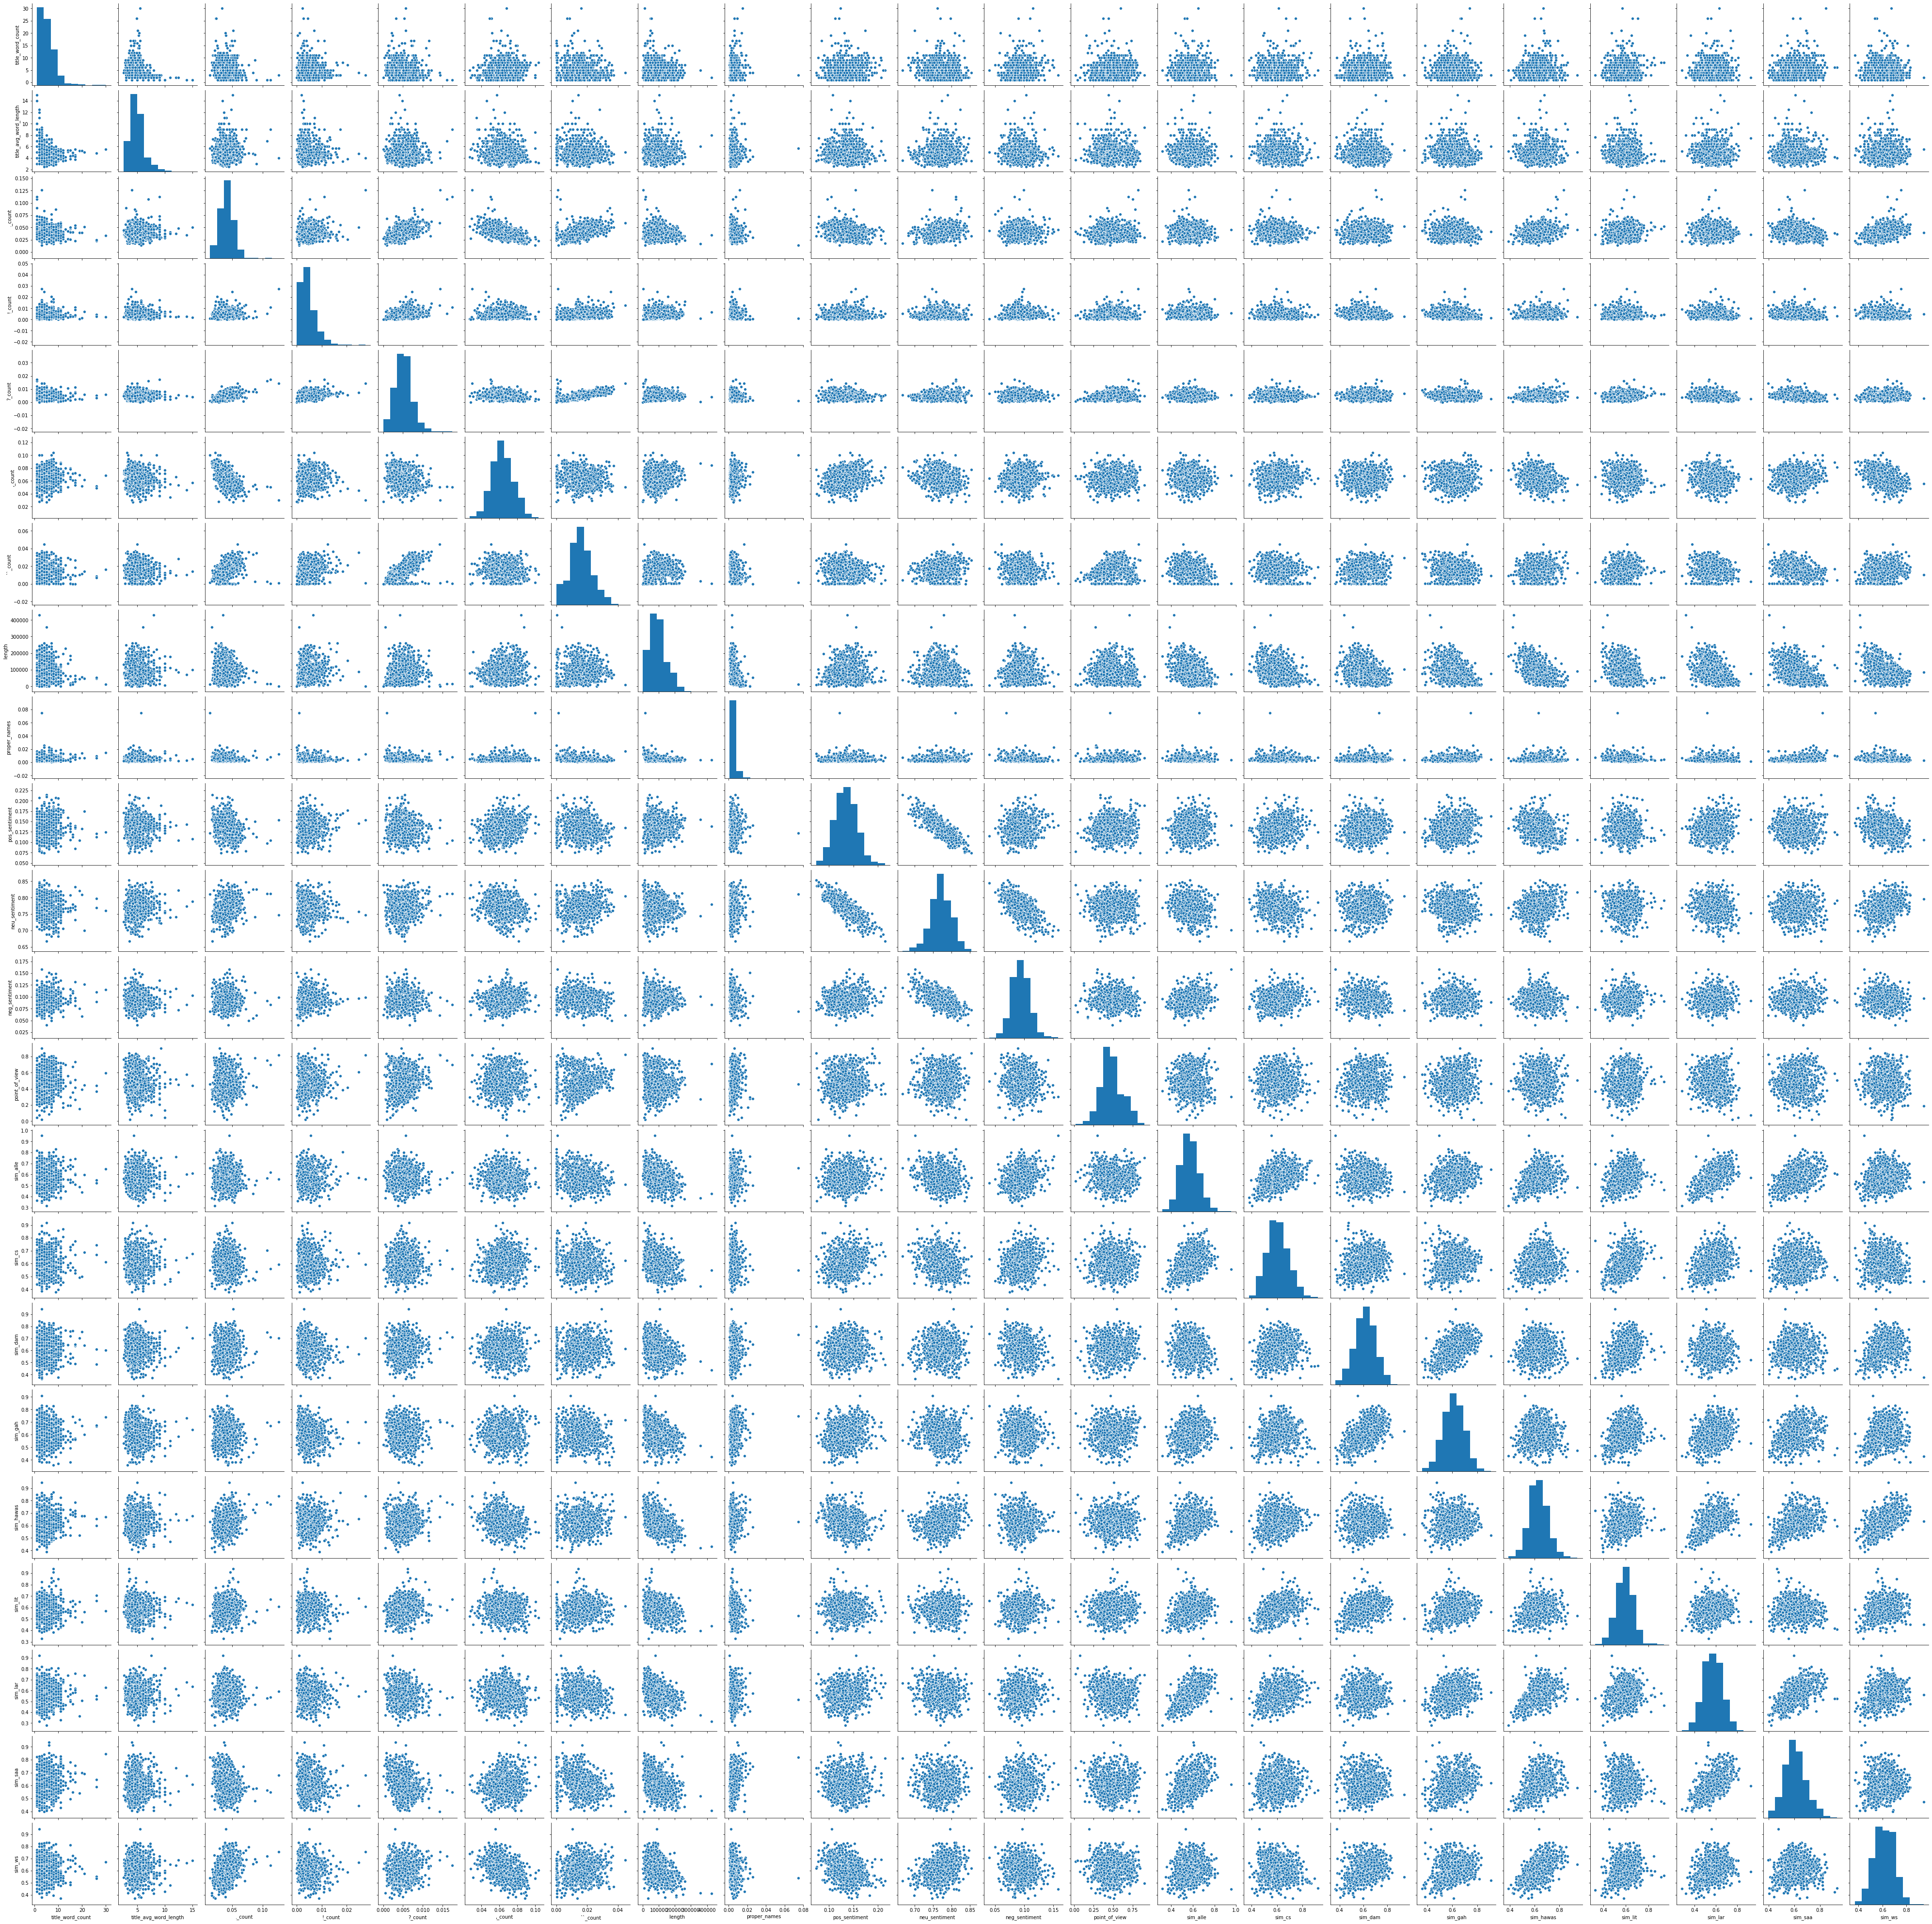

In [24]:
sns.pairplot(feature_collection)

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_collection.dropna())

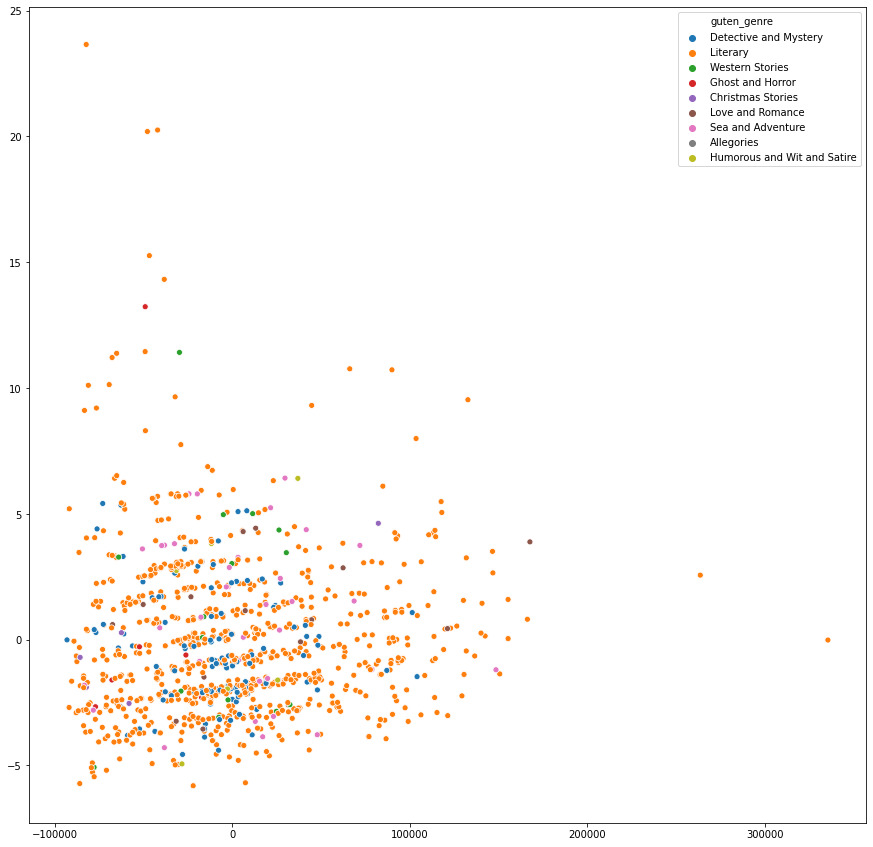

In [108]:
plt.figure(figsize=(15,15))
sns.scatterplot(pca_result.T[0], pca_result.T[1], corpus['guten_genre'][feature_collection.dropna().index])